# Imports

In [8]:
import tensorflow as tf
# from tensorflow.python.framework.ops import disable_eager_execution 
# disable_eager_execution()
# from tensorflow.python.framework.ops import enable_eager_execution
# enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [9]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Import common tensorflow layers and activations
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras.layers import Lambda, Multiply, Add, Rescaling
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras import Input

from local_tabnet import TabNet

In [11]:
BATCH_SIZE = 16384
LAMBDA = 0.0001
N_A = 64
N_D = 64
VIRTUAL_BATCH_SIZE = 512
BATCH_MOMENTUM = 0.7
N_STEPS = 5
GAMMA = 1.5

# Data Defn

In [12]:
dataset_name = 'forestcov'
data = pd.read_csv('covtype.data')

train, test = train_test_split(data, test_size=0.3)

wilderness_areas = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_types = [f"Soil_Type{i}" for i in range(1, 41)]
covariates = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    *wilderness_areas, *soil_types
]
target = "Cover_Type"
features = covariates + [target]
train.columns = features
test.columns = train.columns

iterations_per_epoch = train.shape[0]//BATCH_SIZE
total_iterations = 50000
iterations_to_change_lr = 500
max_epochs = total_iterations//iterations_per_epoch
epochs_to_change_lr = iterations_to_change_lr//iterations_per_epoch

print("Batch size: ", BATCH_SIZE)
print("Total iterations: ", total_iterations)
print("Iterations per epoch: ", iterations_per_epoch)
print("Max epochs: ", max_epochs)
print("Iterations to change lr: ", iterations_to_change_lr)
print("Epochs to change lr: ", epochs_to_change_lr)

# Split into X and y
train_indices, val_indices = train_test_split( np.arange(len(train)), test_size=0.2, random_state=42)

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_val = train[features].values[val_indices]
y_val = train[target].values[val_indices]

X_test = test[features].values
y_test = test[target].values

# Make tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(float), y_train[..., np.newaxis]))
train_dataset = train_dataset.shuffle(buffer_size=4048).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.astype(float), y_val[..., np.newaxis]))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.astype(float), y_test[..., np.newaxis]))
test_dataset = test_dataset.batch(BATCH_SIZE)
print(train_dataset.element_spec, val_dataset.element_spec, test_dataset.element_spec)

Batch size:  16384
Total iterations:  50000
Iterations per epoch:  24
Max epochs:  2083
Iterations to change lr:  500
Epochs to change lr:  20
(TensorSpec(shape=(16384, 55), dtype=tf.float64, name=None), TensorSpec(shape=(16384, 1), dtype=tf.int64, name=None)) (TensorSpec(shape=(16384, 55), dtype=tf.float64, name=None), TensorSpec(shape=(16384, 1), dtype=tf.int64, name=None)) (TensorSpec(shape=(None, 55), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))


# Model creation and training

In [13]:
%autoreload 2

local_implementation = TabNet(
    dim_features=X_train.shape[1],
    dim_attention=N_A, 
    dim_output=10, 
    sparsity=LAMBDA,
    num_steps=N_STEPS,
    gamma=GAMMA,  
    output_activation=None)

# Exponential decay learning rate
lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=iterations_to_change_lr,
    decay_rate=0.95,
    staircase=True
)

local_implementation.compile( 
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
local_implementation.build(X_train[:1].shape)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, monitor="val_accuracy")
history = local_implementation.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/1000
19/19 [==============================] - 80s 4s/step - loss: 1.4304 - accuracy: 0.5142 - val_loss: 0.0000e+00 - val_accuracy: 0.4660
Epoch 2/1000
19/19 [==============================] - 73s 4s/step - loss: 0.8627 - accuracy: 0.6414 - val_loss: 0.0000e+00 - val_accuracy: 0.4593
Epoch 3/1000
19/19 [==============================] - 82s 4s/step - loss: 0.7983 - accuracy: 0.6532 - val_loss: 0.0000e+00 - val_accuracy: 0.5399
Epoch 4/1000
19/19 [==============================] - 93s 5s/step - loss: 0.7659 - accuracy: 0.6672 - val_loss: 0.0000e+00 - val_accuracy: 0.5427
Epoch 5/1000
19/19 [==============================] - 89s 5s/step - loss: 0.7520 - accuracy: 0.6728 - val_loss: 0.0000e+00 - val_accuracy: 0.5134
Epoch 6/1000
19/19 [==============================] - 86s 5s/step - loss: 0.7614 - accuracy: 0.6691 - val_loss: 0.0000e+00 - val_accuracy: 0.5797
Epoch 7/1000
19/19 [==============================] - 86s 5s/step - loss: 0.7135 - accuracy: 0.6810 - val_loss: 0.0000e+00 -

KeyboardInterrupt: 

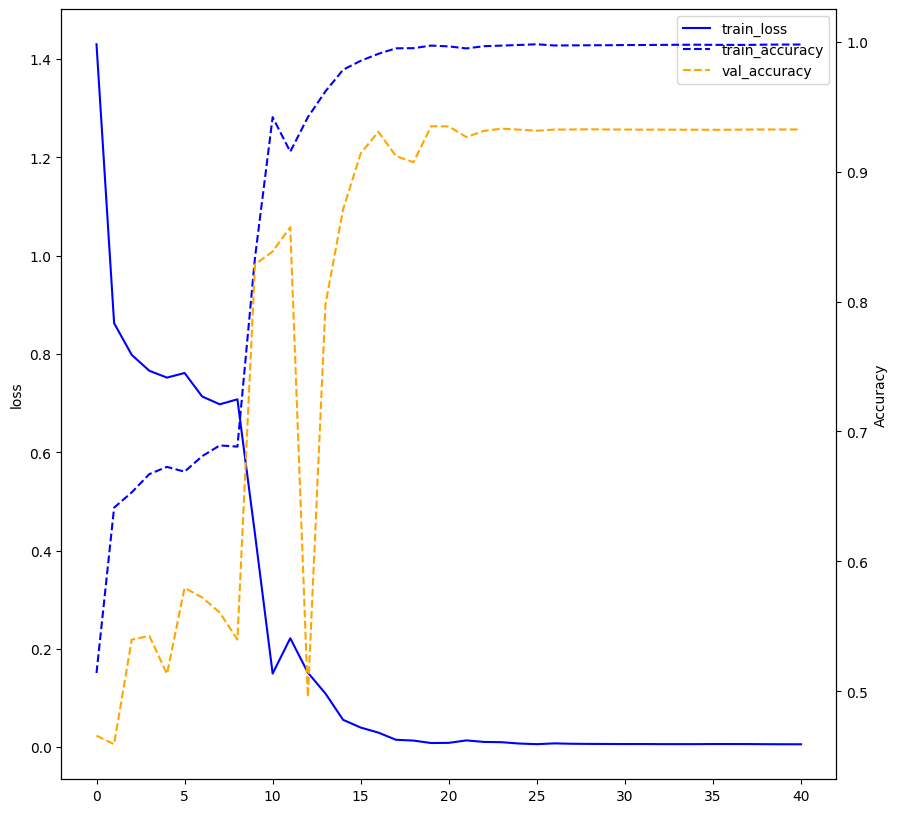

In [15]:
# Plot history loss and RMSE for training and validation set; train solid line, validation dashed line
fig, (top_ax) = plt.subplots(1,1, figsize=(10, 10), sharex=True)

hist = local_implementation.history.history

top_ax.plot(hist['loss'], label='train_loss', c='b')
second_ax = top_ax.twinx()
# Plot precision and recall on second axis in orange and red respectively
second_ax.plot(hist['accuracy'], label='train_accuracy', linestyle='--', c='b')
second_ax.plot(hist['val_accuracy'], label='val_accuracy', linestyle='--', c='orange')
top_ax.set_ylabel('loss')
second_ax.set_ylabel('Accuracy')
# Merge top ax legend entries
handles, labels = top_ax.get_legend_handles_labels()
handles2, labels2 = second_ax.get_legend_handles_labels()
top_ax.legend(handles + handles2, labels + labels2)


In [16]:
# Evaluate model on test set
local_implementation.evaluate(test_dataset)

11/11 [==============================] - 13s 807ms/step - loss: 0.0000e+00 - accuracy: 0.9317


[0.0, 0.9316883087158203]